In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


In [34]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import cv2
from sklearn.model_selection import train_test_split

In [16]:
!unzip /content/drowsiness_data.zip -d /content/input

Archive:  /content/drowsiness_data.zip
  inflating: /content/input/train/Closed/_0.jpg  
  inflating: /content/input/train/Closed/_1.jpg  
  inflating: /content/input/train/Closed/_10.jpg  
  inflating: /content/input/train/Closed/_100.jpg  
  inflating: /content/input/train/Closed/_101.jpg  
  inflating: /content/input/train/Closed/_102.jpg  
  inflating: /content/input/train/Closed/_103.jpg  
  inflating: /content/input/train/Closed/_104.jpg  
  inflating: /content/input/train/Closed/_105.jpg  
  inflating: /content/input/train/Closed/_106.jpg  
  inflating: /content/input/train/Closed/_107.jpg  
  inflating: /content/input/train/Closed/_108.jpg  
  inflating: /content/input/train/Closed/_109.jpg  
  inflating: /content/input/train/Closed/_11.jpg  
  inflating: /content/input/train/Closed/_110.jpg  
  inflating: /content/input/train/Closed/_111.jpg  
  inflating: /content/input/train/Closed/_112.jpg  
  inflating: /content/input/train/Closed/_113.jpg  
  inflating: /content/input/tra

In [17]:
import numpy as np
import pandas as pd
import os
import cv2

# classes

In [18]:
classes = os.listdir("/content/input/train")

In [19]:
classes

['yawn', 'Open', 'no_yawn', 'Closed']

# show an image

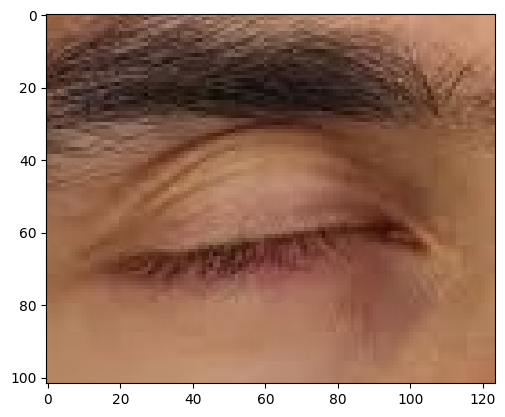

In [20]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/input/train/Closed/_5.jpg"))

In [23]:
a = plt.imread("/content/input/train/yawn/41.jpg")

# image shape

In [24]:
a.shape

(480, 640, 3)

# For yawn image

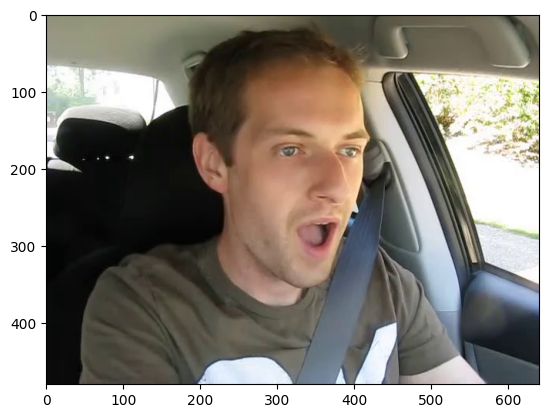

In [25]:
plt.imshow(plt.imread("/content/input/train/yawn/41.jpg"))

In [27]:
import os
import cv2

def face_for_yawn(direc="/content/input/train", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = {"yawn": 0, "no_yawn": 1}

    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category, class_num in categories.items():
        path_link = os.path.join(direc, category)

        for image_name in os.listdir(path_link):
            image_path = os.path.join(path_link, image_name)
            image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

            faces = face_cascade.detectMultiScale(image_array, scaleFactor=1.3, minNeighbors=5)

            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num])

    return yaw_no

yawn_no_yawn = face_for_yawn()

# for closed and open eye

In [28]:
def get_data(dir_path="/content/input/train/", face_cas="/content/haarcascade_frontalface_default.xml", eye_cas="/content/input/haarcascade.xml"):
    classes = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    face_cascade = cv2.CascadeClassifier(face_cas)
    eye_cascade = cv2.CascadeClassifier(eye_cas)

    for label in classes:
        path = os.path.join(dir_path, label)
        class_num = classes.index(label) + 2

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

                gray_img = cv2.cvtColor(resized_array, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)

                for (x, y, w, h) in faces:
                    face_roi = gray_img[y:y+h, x:x+w]

                    eyes = eye_cascade.detectMultiScale(face_roi)

                    if len(eyes) > 0:
                        data.append([resized_array, class_num])
                        break
            except Exception as e:
                print(e)

    return data

data = get_data()

In [29]:
data_train = get_data()

In [30]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return yaw_no

In [31]:
new_data = append_data()

In [32]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [33]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# Binarize

In [35]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [36]:
y = np.array(y)

# train test split

In [37]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [38]:
len(X_test)

142

# Data Augmentation

In [39]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [40]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 389s 9s/step - loss: 1.1203 - accuracy: 0.5412 - val_loss: 0.9676 - val_accuracy: 0.6730
Epoch 2/50
43/43 [==============================] - 425s 10s/step - loss: 0.5610 - accuracy: 0.7543 - val_loss: 0.3961 - val_accuracy: 0.8131
Epoch 3/50
43/43 [==============================] - 418s 10s/step - loss: 0.4480 - accuracy: 0.8025 - val_loss: 0.3492 - val_accuracy: 0.8512
Epoch 4/50
43/43 [==============================] - 376s 9s/step - loss: 0.4169 - accuracy: 0.8196 - val_loss: 0.3103 - val_accuracy: 0.8651
Epoch 5/50
43/43 [==============================] - 415s 10s/step - loss: 0.3549 - accuracy: 0.8515 - val_loss: 0.3111 - val_accuracy: 0.8824
Epoch 6/50
43/43 [==============================] - 414s 10s/step - loss: 0.3056 - accuracy: 0.8679 - val_loss: 0.2815 - val_accuracy: 0.8927
Epoch 7/50
43/43 [==============================] - 415s 10s/step - loss: 0.2499 - accuracy: 0.8909 - val_loss: 0.2385 - val_accuracy: 0.8979
Epoch 8/

# history

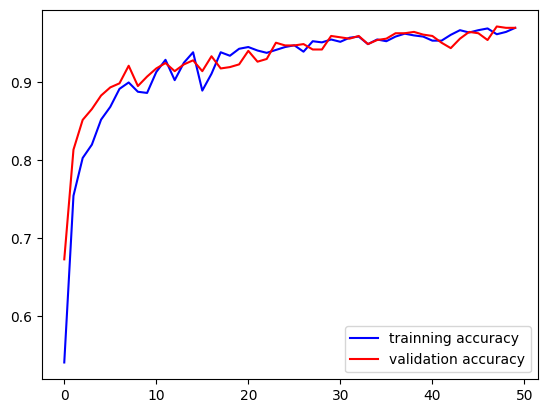

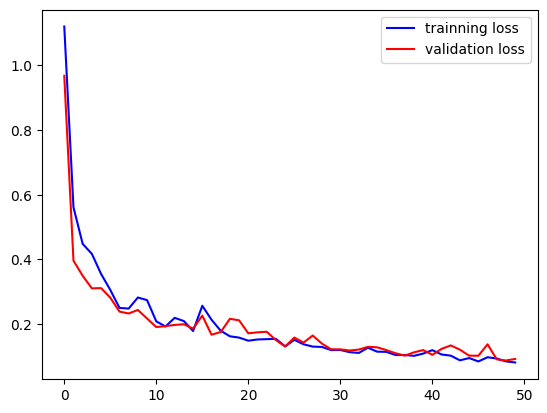

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [ ]:
model.save("/content/drowiness_new6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction

In [ ]:
predictions = model.predict(X_test)

prediction = np.argmax(predictions, axis=1)

19/19 [==============================] - 43s 2s/step


In [ ]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 1, 0, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 2,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 2, 2, 1, 3, 2, 3, 1, 2, 0, 1, 3, 2, 2, 3, 3, 3, 1,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 2, 2, 3, 3, 3, 1, 1, 2, 0, 1, 3, 3, 1, 2, 3, 1, 3, 3, 0, 0,
       0, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 1, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 1, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [ ]:
classes_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=classes_new))

              precision    recall  f1-score   support

        yawn       0.94      0.71      0.81        63
     no_yawn       0.81      0.96      0.88        74
      Closed       0.97      0.99      0.98       215
        Open       0.99      0.97      0.98       226

    accuracy                           0.95       578
   macro avg       0.93      0.91      0.91       578
weighted avg       0.95      0.95      0.95       578



# predicting function

In [59]:
categories = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145

def preprocess_img(filepath, face_cas="/content/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    preprocess_img = resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return preprocess_img

model = tf.keras.models.load_model("./drowiness_new6.h5")

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [60]:
prediction = model.predict([preprocess_img("/content/input/train/yawn/102.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 125ms/step


3

In [61]:
prediction = model.predict([preprocess_img("/content/input/train/no_yawn/1031.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 30ms/step


0

In [62]:
prediction = model.predict([preprocess_img("/content/input/train/Closed/_107.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 26ms/step


2

In [63]:
prediction = model.predict([preprocess_img("/content/input/train/Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 30ms/step


3